In [129]:
# Author: Davide Aloi - PhD student - University of Birmingham
# Description: the script loads the results from wp_all_8_current_density_metrics, which are 3
# .csv files, and correlates current density metrics with DCM values.
# The analysis method used is Canonical correlation analysis (CCA)
# Imports
import warnings
warnings.filterwarnings("ignore")
import os
import numpy as np
import pandas as pd
import scipy.stats

In [130]:
## Parameters and variables: 
results_folder = 'D:\\roast-chapter3\\wp_all_results\\' # Folder with results (current density)
main_folder = 'C:\\Users\\davide\\Documents\\GitHub\\wp1_2_roast\\' # Project folder
dcm_results_folder = 'C:\\Users\\davide\\Documents\\GitHub\\wp1_2_roast\\all_dcm_results\\' # Folder with dcm results

# Datasets names and subjects lists
db_names = ['wp2a', 'wp1b'] # waiting for wp1a results from Davinia
#db_names = ['wp2a']

-------- CCA analysis for dataset wp2a ---------
Current density metrics
   m1_medians    m1_max  th_medians    th_max
0    1.064099 -0.222754   -0.387600  2.239864
1    1.202965  1.111482   -0.967031 -0.837454
2   -0.107853  1.544385   -0.503373  0.143153
3   -0.665023 -1.268581   -0.250689 -0.461470
4    0.777813  0.006170    1.643100 -0.504230

DCM values
       m1m1      thth      m1th      thm1
0 -0.196311 -1.106192 -1.125615 -0.815612
1  1.365279 -0.596032  0.172432 -0.076831
2  1.675969  1.515966 -0.709467  0.424610
3 -2.012348 -0.156342 -0.640999 -0.924352
4  0.116447 -0.357149 -0.165926 -0.092548

Correlations between CV pairs
r=0.65, p=0.00107
r=0.477, p=0.02477
r=0.447, p=0.03677
r=0.108, p=0.63352


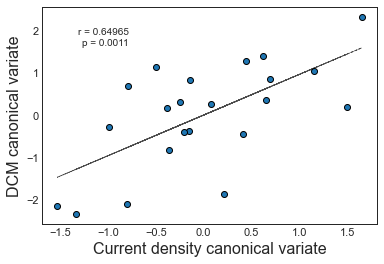


---- CCA analysis db: wp2a ----
Correlations between first current density variate and DCM measures
m1m1: r=-0.53, p=0.01124
thth: r=-0.574, p=0.00525
m1th: r=0.176, p=0.43444
thm1: r=-0.215, p=0.33574

Correlations between first DCM variate and current density measures
m1_medians: r=0.156, p=0.48872
m1_max: r=-0.184, p=0.41347
th_medians: r=0.531, p=0.01094
th_max: r=0.005, p=0.98071


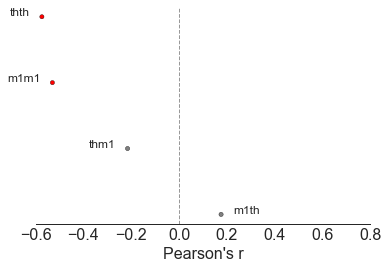

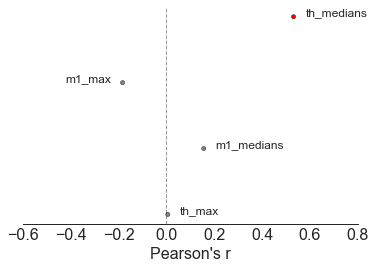

Results combined into single Hlines plot


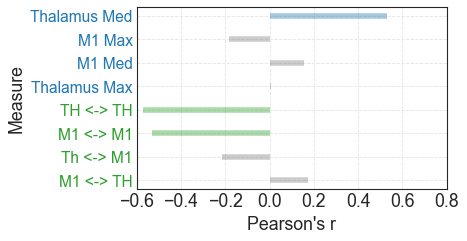

Grey lines: correlation not significant. Coloured line: significant correlation
Blue labels / lines: current density measures. Green labels / lines: DCM measures.
-------- CCA analysis for dataset wp1b ---------
Current density metrics
   m1_medians    m1_max  th_medians    th_max  cb_medians    cb_max
0   -0.158974  0.430269    0.245703 -0.512999    1.663100 -0.427120
1   -0.146091 -0.142630    1.660609  1.232704    1.522388 -0.766634
2   -0.501737 -1.232237   -0.493217 -0.002231    0.228552 -0.610755
3   -1.031940  1.469238   -0.129070 -0.993648    0.211752  1.264327
4   -1.381292 -0.278308    0.010716 -0.939487   -0.394132  1.677613

DCM values
       m1m1      thth      m1th      thm1
0  0.845498  0.498637  0.309924 -0.310996
1 -3.095660 -0.272627 -0.935530 -1.020705
2  1.023944  1.886463  1.555576 -0.936241
3 -1.135870 -0.486223  0.766313  0.388966
4  0.593826  0.844387 -0.248056  0.455699

Correlations between CV pairs
r=0.779, p=3e-05
r=0.551, p=0.00966
r=0.353, p=0.1161
r=0.268

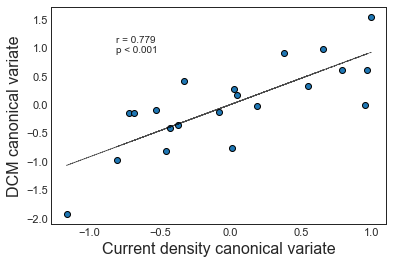


---- CCA analysis db: wp1b ----
Correlations between first current density variate and DCM measures
m1m1: r=-0.151, p=0.51421
thth: r=-0.296, p=0.1919
m1th: r=0.56, p=0.00828
thm1: r=-0.01, p=0.96423

Correlations between first DCM variate and current density measures
m1_medians: r=-0.324, p=0.15232
m1_max: r=-0.037, p=0.87358
th_medians: r=-0.104, p=0.6548
th_max: r=0.261, p=0.25231
cb_medians: r=0.344, p=0.12674
cb_max: r=0.064, p=0.78438


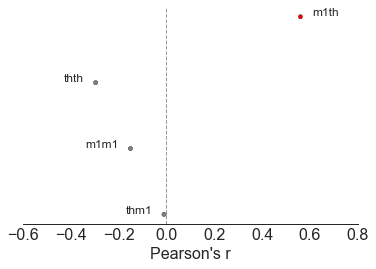

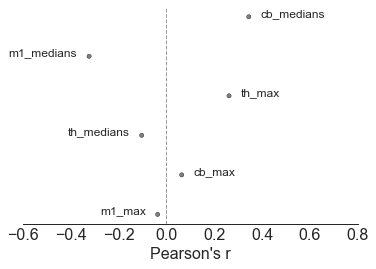

Results combined into single Hlines plot


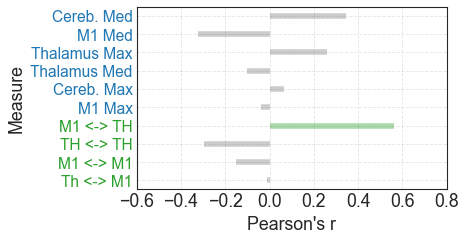

Grey lines: correlation not significant. Coloured line: significant correlation
Blue labels / lines: current density measures. Green labels / lines: DCM measures.


In [147]:
from sklearn.cross_decomposition import CCA

for db_id, db in enumerate(db_names):
    print('-------- CCA analysis for dataset ' + db + ' ---------')

    # Loading DCM results (nb: the unthresholded ones, for the correlation analysis)
    DCM = np.load(os.path.join(dcm_results_folder, db + '_dcm_unthresholded.npy'))
    DCM_sham = np.load(os.path.join(dcm_results_folder, db + '_dcm_sham_unthresholded.npy'))

    # Conversion of diagonal values to Hz + recentering on 0
    funcHz = lambda x: (-0.5*(np.exp(x)))+0.5 if x != 0 else 0
    # Positive values now indicate less self inhibition
    # Negative values indicate more self inhibition
    # NB. Adding 0.5 does not change the relationship / interpretation of the correlations
    for i in range(0, DCM.shape[0]): 
        diag = np.diagonal(DCM[i,:,:])
        diag_converted = []
        for element in diag:
            diag_converted.append(funcHz(element))
        np.fill_diagonal(DCM[i,:,:], np.array(diag_converted))

    # Loading current density results
    cd_metrics = pd.read_csv(os.path.join(results_folder, db +'_current_density_results.csv'))
    cd_metrics.drop('Unnamed: 0', axis = 1, inplace = True) # Dropping participants' id

    # for wp1a and wp2a (stimulatio over M1) I'm not interested in CB values
    if (db == 'wp2a') or (db == 'wp1a'):
        cd_metrics.drop(['cb_medians','cb_max'], axis = 1, inplace = True)

    # Simple R correlation (example)
    #x = cd_metrics['m1_medians'].values # Medians current density in M1
    #y = DCM[:, 0, 0] # NB: DCM index related to m1 <-> m1 (of all subjects) = [0,0]
    #r,p  = scipy.stats.pearsonr(x, y)    # Pearson's r
    #print ('R: ' + str(round(r,3)) + ', p: ' +  str(round(p,3)))

    # Extracting DCM values I am interested in (m1<->m1, th<->th, m1->th, th->m1)
    dcm_df = pd.DataFrame(zip(DCM[:,0,0], DCM[:,1,1], DCM[:,1,0], DCM[:,0,1]),
                                columns = ['m1m1', 'thth', 'm1th',
                                'thm1'])

    # We first standardise our variables by subtracting with mean and dividing by standard deviation
    cd_df_s = (cd_metrics-cd_metrics.mean())/(cd_metrics.std())
    dcm_df_s = (dcm_df-dcm_df.mean())/(dcm_df.std())

    print('Current density metrics')
    print(cd_df_s.head())
    print('\nDCM values')
    print(dcm_df_s.head())

    ''' Damian: Basically your CCA analysis will give you pairs of canonical variates (one of
    each pair that describes the current measures, and one that describes the DCM). For each
    significant pair, you then correlate the CV from one side with each of the individual
    measures from the other side.
    This will basically tell you that e.g., Current density overall is most strongly related to
    DCM connectivity in pathways X and Y, and that DCM connectivity overall is most strongly
    related to current density in region A and B. '''

    # CCA using scikit-learn (X = current measures, Y = DCM measures)
    cca = CCA(n_components = 4, max_iter = 2000)
    cca.fit(cd_df_s, dcm_df_s)
    X_c, Y_c = cca.transform(cd_df_s, dcm_df_s)    

    # Dataframe containing Canonical Variates (CV)
    cc_res = pd.DataFrame({"CCX_1":X_c[:, 0],
                           "CCY_1":Y_c[:, 0],
                           "CCX_2":X_c[:, 1],
                           "CCY_2":Y_c[:, 1]})

    # Correlation between pairs of canonical variates 
    r1,p1  = scipy.stats.pearsonr(X_c[:, 0], Y_c[:, 0])
    r2,p2  = scipy.stats.pearsonr(X_c[:, 1], Y_c[:, 1])

    
    print('\nCorrelations between CV pairs')
    for i in range(0,len(X_c[0,:])):
        this_CV_r, this_CV_p = scipy.stats.pearsonr(X_c[:, i], Y_c[:, i])
        print('r=' + str(round(this_CV_r,3)) + ', p=' +  str(round(this_CV_p,5)))


    ### PLOT 1) Ploting correlation between 1st pair of CVs
    import matplotlib.pyplot as plt
    from numpy.polynomial.polynomial import polyfit
    x, y = X_c[:,0], Y_c[:,0]
    b, m = polyfit(x, y, 1)
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['figure.facecolor'] = 'white'
    plt.scatter(x, y, edgecolors= "black")
    plt.xlabel('Current density canonical variate')
    plt.ylabel('DCM canonical variate')
    plt.plot(x, b + m * x, '--',color='black', linewidth=0.8, alpha = 0.7)
    plt.tick_params(axis='both', which='major', labelsize=11)

    text = 'r = ' + str(round(r1, 5)) + ' \np = ' + str(round(p1,4))
    if p1 < 0.001:
        text = 'r = ' + str(round(r1, 3)) + ' \np < 0.001' 

    plt.text(np.min(x)+0.5, np.max(y)-0.5, text , horizontalalignment='center',
                        verticalalignment='center', fontsize = 10)
    plt.show()
    ###

    ## CCA correlations
    # Correlation of DCM values with first current density CV (X_c[:,0])    
    r_list_dcm = [] # list of R for the dcm values
    p_list_dcm = [] # list of p values
    print( '\n----' + ' CCA analysis db: '+ db + ' ----')
    print('Correlations between first current density variate and DCM measures')
    for DCM_measure in dcm_df_s:
        r, p = scipy.stats.pearsonr(X_c[:, 0], dcm_df_s[DCM_measure])
        print(DCM_measure +': r=' + str(round(r,3)) + ', p=' +  str(round(p,5)))
        r_list_dcm.append(r)
        p_list_dcm.append(p)

    # Correlation of Current density values with first DCM covariate (Y_c[:,0])
    r_list_cd = [] # list of R for the current density values
    p_list_cd = [] # list of p values

    print('\nCorrelations between first DCM variate and current density measures')
    for CD_measure in cd_df_s:
        r, p = scipy.stats.pearsonr(Y_c[:, 0], cd_df_s[CD_measure])
        print(CD_measure +': r=' + str(round(r,3)) + ', p=' +  str(round(p,5)))
        r_list_cd.append(r)
        p_list_cd.append(p)

    ## Storing R and P values in 2 dataframes, one for the DCM metrics and one for the 
    # current density metrics. These will be used for plotting results.
    df_dcm_res = pd.DataFrame({"measure": dcm_df_s.columns,
                            "r": r_list_dcm,
                           "p":p_list_dcm})

    df_cd_res = pd.DataFrame({"measure": cd_df_s.columns,
                            "r": r_list_cd,
                           "p":p_list_cd})
    
    ### PLOT 2) Plotting scatterplots with R values as in:
    # https://www.sciencedirect.com/science/article/pii/S2213158220302096
    # Red dots: significant correlations. Grey dots: p<0.05
    # values are ordered on the y axis based on their p-value (higher R: higher Y)

    import seaborn as sns
    results = [df_dcm_res, df_cd_res]

    for result in results:
        df_cor = result
        # Ordering measures based on their P-values           
        df_cor = df_cor.sort_values(by=['r'], key = abs, ascending = False).reset_index(drop=True)
        df_cor['rank'] = np.flip(df_cor.index.values)
        df_cor['sig'] =  np.where(df_cor['p'] < 0.05, 'sig', 'not-sig')
        df_cor['col'] = np.where(df_cor['p'] < 0.05, 'red', 'gray')

        ax = sns.scatterplot('r', # Horizontal axis
                'rank', # Vertical axis
                data = df_cor, # Data source
                size = 10,
                hue = 'col',
                edgecolor="black",
                palette = list(dict.fromkeys(df_cor.col)),
                legend = False) 

        ax.set_xticks(np.arange(-1,1,0.2)) # increasing n of x-ticks
        ax.set_xlabel("Pearson's r")
        plt.rcParams['figure.facecolor'] = 'white'
        plt.rcParams['font.family'] = 'sans-serif'
        plt.xlim(-0.6,0.8)
        sns.despine(left=True)
        plt.gca().axes.get_yaxis().set_visible(False)
        plt.axvline(x=0, color='k', linestyle='--', alpha = 0.4, linewidth = 1)

        # Plotting measures' names
        for i, measure in enumerate (df_cor.measure):
            off_x = 0.05
            al = 'left'
            if df_cor.r[i] < 0:
                off_x = -0.05
                al = 'right' 
            plt.text(df_cor.r[i]+off_x, df_cor['rank'].values[i]+0.01, measure, fontdict={'size': 12, 'ha': al})
        plt.show()

    ## PLOT 3) Results combined
    print('Results combined into single Hlines plot')
    results[0]['measure_group'] = 'DCM'
    results[1]['measure_group'] = 'CD'
    results[0] = results[0].sort_values(by=['r'], key = abs, ascending = False).reset_index(drop=True)
    results[1] = results[1].sort_values(by=['r'], key = abs, ascending = False).reset_index(drop=True)
    results[0]['col'] = np.where(results[0]['p'] < 0.05, 'tab:green', 'gray')
    results[1]['col'] = np.where(results[1]['p'] < 0.05, 'tab:blue', 'gray')
    results[0]['rank'] = np.flip(results[0].index.values)
    results[1]['rank'] = np.flip(results[1].index.values) + results[0].shape[0]
    
    # Renaming some rows for clearer labels!
    results[1]['measure'] = results[1]['measure'].str.replace('_medians',' Med')
    results[1]['measure'] = results[1]['measure'].str.replace('_max',' Max')
    results[1]['measure'] = results[1]['measure'].str.replace('cb','Cereb.')
    results[1]['measure'] = results[1]['measure'].str.replace('m1','M1')
    results[1]['measure'] = results[1]['measure'].str.replace('th','Thalamus')
    
    results[0]['measure'] = results[0]['measure'].str.replace('m1m1','M1 <-> M1')
    results[0]['measure'] = results[0]['measure'].str.replace('thth','TH <-> TH')
    results[0]['measure'] = results[0]['measure'].str.replace('m1th','M1 <-> TH')
    results[0]['measure'] = results[0]['measure'].str.replace('thm1','Th <-> M1')
    
    # Combining two datasets together (cd measures and dcm measures)
    df_all = pd.concat([results[0], results[1]], ignore_index=True)
    df_all['sig'] =  np.where(df_all['p'] < 0.05, 'sig', 'not-sig')

    # Plot
    plt.figure(figsize=(5,3), dpi= 80)
    plt.hlines(y=df_all['rank'], xmin=0, xmax=df_all['r'], color=df_all.col, alpha=0.4, linewidth=5)

    # Decorations
    plt.gca().set(ylabel='Measure', xlabel="Pearson's r")
    plt.yticks(df_all['rank'], df_all.measure, fontsize=14)
    mycolors = ['tab:green' if x == 'DCM' else 'tab:blue' for x in df_all['measure_group']] 
    for ticklabel, tickcolor in zip(plt.gca().get_yticklabels(), mycolors):
        ticklabel.set_color(tickcolor)
    plt.grid(linestyle='--', alpha=0.5)
    plt.xticks(np.arange(-1,1,0.2)) # increasing n of x-ticks

    plt.xlim(-0.6,0.8)
    plt.show()
    print('Grey lines: correlation not significant. Coloured line: significant correlation')
    print('Blue labels / lines: current density measures. Green labels / lines: DCM measures.')
    ###



In [132]:
# plot styles
large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
%matplotlib inline

In [138]:
DCM[0,:]

array([[-0.46217123, -0.11196711,  0.08734463, -0.28352095],
       [ 0.03255551, -0.49749038,  0.04029294, -0.01355012],
       [ 0.19550484, -0.05182206, -0.48658895, -0.00410529],
       [ 0.02143408, -0.0593897 , -0.28144679, -0.53552681]])